<a href="https://colab.research.google.com/github/vanyagoncharov/CourseMLResourse/blob/main/dz_23_s3e6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозировании цен на жилье в Париже

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import graphviz

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error

from mlxtend.plotting import plot_decision_regions


## Функции

## Загрузка данных

In [2]:
# Загружаем тестовый и тренировочный наборы данных
data_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/playground-series-s3e6/test.csv')
data_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/playground-series-s3e6/train.csv')

In [3]:
# Удаление ненужных столбцов, которые могут не способствовать прогнозированию модели.
data_test = data_test.drop(['id', 'cityCode'], axis=1)
data_train = data_train.drop(['id', 'cityCode'], axis=1)

In [4]:
data_test

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
0,47580,89,0,1,8,5,3,1995,0,0,6885,8181,241,0,8
1,62083,38,0,0,87,10,3,1994,1,1,4601,9237,393,1,4
2,90499,75,1,1,37,9,6,1997,0,1,7454,2680,305,0,2
3,16354,47,1,1,9,6,5,2019,1,1,705,5097,122,1,5
4,67510,8,0,0,55,3,7,2014,1,1,3715,7979,401,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15149,86184,74,1,1,73,2,10,1993,1,0,3714,3894,665,1,1
15150,45885,41,1,1,64,4,5,2008,0,0,783,7628,976,0,0
15151,73554,51,0,0,41,10,5,2004,0,1,8207,1777,775,0,10
15152,77604,51,0,1,33,4,3,2019,0,0,9578,9706,135,0,2


In [5]:
data_train

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,34291,24,1,0,47,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,95145,60,0,1,60,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,92661,45,1,1,62,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,97184,99,0,0,59,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,61752,100,0,0,57,8,4,2018,1,0,7151,2786,863,0,7,6181908.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22725,55825,84,1,0,70,3,10,2000,0,0,4477,786,345,0,0,5594137.1
22726,65870,88,1,0,49,9,9,2015,0,1,4811,2454,755,0,7,6594705.0
22727,93192,42,1,0,39,10,5,2014,1,0,5595,4072,789,0,0,9321511.4
22728,65797,86,1,0,89,2,10,2000,1,0,5358,2513,411,0,0,6584708.2


## Разведочный анализ данных

### Общий анализ данных

In [6]:
pd.value_counts(data_train.dtypes)

int64      15
float64     1
dtype: int64

In [7]:
pd.value_counts(data_test.dtypes)

int64    15
dtype: int64

### Сколько строк в датафрейме, сколько столбцов

In [8]:
# Вывод информации о датасете
print(f'Информация о датасете: \n {data_train.shape[0]}: строк\n {data_train.shape[1]}: столбцов')

Информация о датасете: 
 22730: строк
 16: столбцов


### Сколько места занимает датафрейм в оперативной памяти

In [9]:
print(f'{np.round(data_train.memory_usage(index=True).sum() / 1024, 4)} КБ: занимаемый объем памяти')

2841.375 КБ: занимаемый объем памяти


### Для каждой интервальной переменной подсчитать следующее - мин, медиана, среднее, макс и персентили 25, 75

In [10]:
data_train.describe()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
count,2.273000e+04,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,2.273000e+04
mean,4.658622e+04,48.241091,0.475891,0.452750,47.305983,5.585042,5.620766,2008.005059,0.467972,0.460009,5283.646634,5067.981698,530.469644,0.461681,5.153058,4.634457e+06
std,4.952124e+04,28.226428,0.499429,0.497773,47.777207,2.739533,2.713026,118.826777,0.498984,0.498409,3047.084412,3097.347939,274.840604,0.498540,3.055246,2.925163e+06
min,8.900000e+01,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1990.000000,0.000000,0.000000,4.000000,1.000000,4.000000,0.000000,0.000000,1.031350e+04
25%,2.039275e+04,25.000000,0.000000,0.000000,25.000000,3.000000,3.000000,2000.000000,0.000000,0.000000,2977.250000,2599.000000,297.000000,0.000000,3.000000,2.041739e+06
50%,4.448400e+04,47.000000,0.000000,0.000000,45.000000,6.000000,6.000000,2006.000000,0.000000,0.000000,5359.000000,4977.000000,515.000000,0.000000,5.000000,4.450823e+06
75%,7.154700e+04,75.000000,1.000000,1.000000,69.000000,8.000000,8.000000,2014.000000,1.000000,1.000000,7746.000000,7652.000000,767.000000,1.000000,8.000000,7.159920e+06
max,6.071330e+06,100.000000,1.000000,1.000000,6000.000000,10.000000,10.000000,10000.000000,1.000000,1.000000,91992.000000,96381.000000,9017.000000,1.000000,10.000000,1.000428e+07


### Для каждой категориальной переменной рассчитать моду и сколько раз мода встречается в данных

Исходя из анализа выше было видно, что категориальные переменные отсутствуют

## Подготовка датасета к построению моделей ML

### Провести анализ и обработку пропусков (либо заменить, либо удалить)

In [11]:
data_test.isnull().sum()

squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
dtype: int64

In [12]:
data_train.isnull().sum()

squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
price                0
dtype: int64

Пропуски в датасете отсутствуют

### Провести анализ и обработку выбросов (либо заменить, либо удалить)

In [13]:
# найдем границы 1.5 * IQR по каждому столбцу
Q1 = data_train.quantile(0.25)
Q3 = data_train.quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

# создадим маску для выбросов
# (если хотя бы один выброс в строке (True), метод .any() сделает всю строку True
mask_out = ((data_train < lower) | (data_train > upper)).any(axis = 1)
# обратное условие, если все значения по всем строкам внутри границ метод .all() выдаст True
mask_no_out = ((data_train >= lower) & (data_train <= upper)).all(axis = 1)

In [14]:
# найдем выбросы во всем датафрейме
data_train[mask_out]

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
2107,28956,100,0,1,35,6,9,2000,0,1,84333,8777,655,0,1,2898953.1
2113,68038,41,0,0,54,3,6,10000,1,1,6537,6304,366,0,0,6807415.1
3608,80062,81,1,0,35,9,4,10000,0,1,732,6475,758,0,4,8007951.1
3828,31357,80,0,1,35,9,4,2017,1,0,1284,71001,212,0,5,3141062.7
3995,43758,14,0,0,93,3,9,2008,0,0,81851,9179,243,0,2,4385098.8
4909,26484,33,0,1,37,5,3,1997,1,1,774,71001,663,0,1,2654798.7
5659,65029,50,0,1,6000,4,5,2012,0,1,5123,230,668,0,4,6507042.1
12858,93278,41,1,1,56,9,8,2015,0,1,4145,71024,473,0,3,9339538.5
13633,53708,81,0,0,84,7,6,2006,1,1,759,96381,860,1,8,5378041.6
13642,14588,36,0,0,16,5,2,2003,0,1,5361,30000,357,0,4,1459601.3


In [15]:
# сохраняем датасет без выбросов
data_train_iqr = data_train[mask_no_out]

### Провести анализ и обработку категориальных переменных (сколько таких переменных, закодируйте категориальные переменные одним из методов ( one hot encoding, mean target, frequence encoding)

Исходя из анализа выше было видно, что категориальные переменные отсутствуют

### Разделить датасет на трейн и тест

In [16]:
# Разделение данные на целевую переменную и признаки
X = data_train_iqr.iloc[:, :-1]
y = data_train_iqr.iloc[:, -1]

In [17]:
# Разделение данных на обучающую выборку и валидационную выборку
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

## Обучить любые 2 алгоритма:

### SVM

### Decision tree

In [33]:
# Создание экземпляра модели регрессора дерева решений
regressor = DecisionTreeRegressor()

# Определение сетки параметров для GridSearchCV
param_grid = {
    'criterion': ['mse', 'friedman_mse', 'mae'],
    'max_depth': [None, 1, 2, 3, 4],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

# Создание экземпляра GridSearchCV для подбора параметров
grid_search = GridSearchCV(regressor, param_grid, cv=5)

# Обучение модели с использованием GridSearchCV
grid_search.fit(X_train, y_train)

# Выводим наилучшие параметры и точность на тестовой выборке
print("Наилучшие параметры: ", grid_search.best_params_)
print("Точность на тестовой выборке: ", grid_search.best_score_)


Наилучшие параметры:  {'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5}
Точность на тестовой выборке:  0.9962683754635269


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
300 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 1247, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _val

In [34]:
# Обучение модели с использованием наилучших параметров
best_regressor = DecisionTreeRegressor(**grid_search.best_params_)
best_regressor.fit(X_train, y_train)


DecisionTreeRegressor(criterion='friedman_mse', min_samples_leaf=4,
                      min_samples_split=5)

In [35]:
# Оценка модели на тестовых данных
test_score = best_regressor.score(X_test, y_test)
print("Test R^2 score:", test_score)

Test R^2 score: 0.9956982864532341


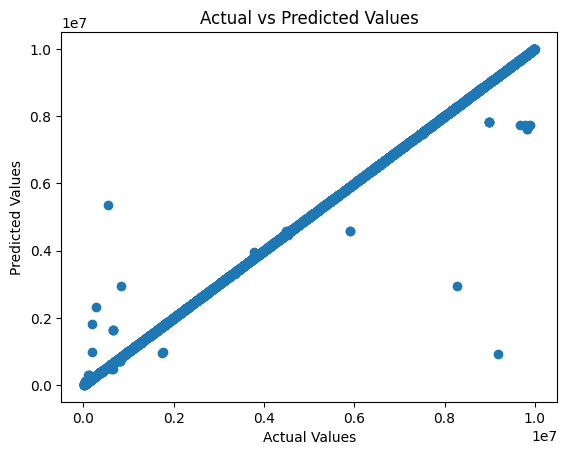

In [36]:
import matplotlib.pyplot as plt

# Получение предсказаний модели
y_pred = best_regressor.predict(X_test)

# Визуализация предсказаний
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

In [37]:
from sklearn.metrics import mean_squared_error

# Получение предсказаний на обучающих и тестовых данных
y_train_pred = best_regressor.predict(X_train)
y_test_pred = best_regressor.predict(X_test)

# Вычисление среднеквадратичной ошибки
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Train MSE:", train_mse)
print("Test MSE:", test_mse)

Train MSE: 21683331365.71377
Test MSE: 36995460883.537895


## Оценить качество алгоритмов, выбрать самый оптимальный алгоритм

Затем сравните их производительность, используя метрики, такие как MAE, MSE, R^2, на тестовых данных. Обоснуйте свой выбор лучшей модели, учитывая точность
прогнозирования и обобщающую способность на новых данных